In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs

import warnings

warnings.filterwarnings("ignore")

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [ ]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [4]:
# download our example of tabular data: spotify-2023-short.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/spotify-2023-short.csv

File ‘spotify-2023-short.csv’ already there; not retrieving.



In [5]:
dataset = rf.Dataset.from_csv("Spotify", "spotify-2023-short.csv")
dataset.to_pandas()

,released_year,released_month,released_day,in_spotify_playlists,bpm,key,mode
0,2023,7,14,553,125,B,Major
1,2023,3,23,1474,92,C#,Major
2,2023,6,30,1397,138,F,Major
3,2019,8,23,7858,170,A,Major
4,2023,5,18,3133,144,A,Minor
...,...,...,...,...,...,...,...
95,2023,5,12,2175,143,D#,Major
96,2023,3,17,2000,100,F#,Minor
97,2022,12,9,2839,143,F,Major
98,2011,1,1,20333,112,C#,Minor


In [ ]:
cat_fields = "released_year released_month released_day key mode".split()
con_fields = "in_spotify_playlists bpm".split()
train_config = ra.TrainTabTransformer.Config(
    encoder=ra.TrainTabTransformer.DatasetConfig(
        metadata=[
            ra.TrainTabTransformer.FieldConfig(field=field, type="categorical")
            for field in cat_fields
        ]
        + [
            ra.TrainTabTransformer.FieldConfig(field=field, type="continuous")
            for field in con_fields
        ]
    ),
    rtf=ra.TrainTabTransformer.TrainConfig(
        num_bootstrap=2,
        epochs=1,
        gpt2_config=ra.TrainTabTransformer.GPT2Config(
            layer=1, head=1, embed=1
        ),
    ),
)
# create the train action
train = ra.TrainTabTransformer(train_config)

In [7]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)

print(f"Workflow: {workflow.id()}")

Workflow: 2u1M20FFXSr7QB913HmlBj


In [8]:
async for log in workflow.logs():
    print(log)

2025-02-27T22:35:07Z dataset-load: INFO Downloading dataset '6EUMJ23pq2AbEi4Yn4pgDI'
2025-02-27T22:35:08Z dataset-load: INFO Downloaded dataset '6EUMJ23pq2AbEi4Yn4pgDI' with 100 rows
2025-02-27T22:42:28Z train-tab-transformer: WARN Missing values detected in Field "key".
2025-02-27T22:42:29Z train-tab-transformer: INFO Start training...
2025-02-27T22:42:35Z train-tab-transformer: INFO Epoch 1 completed.
2025-02-27T22:42:45Z train-tab-transformer: INFO Training completed. The Model ID is 27fae49e-f55c-11ef-bf1b-d27724d2d9bb


In [9]:
model = await workflow.models().last()
model

Model(id='27fae49e-f55c-11ef-bf1b-d27724d2d9bb', labels={'workflow_id': '2u1M20FFXSr7QB913HmlBj'}, create_time=datetime.datetime(2025, 2, 27, 22, 42, 42, tzinfo=datetime.timezone.utc), size_bytes=127776768)

In [ ]:
generate_config = ra.GenerateTabTransformer.Config()
generate = ra.GenerateTabTransformer(generate_config)
save = ra.DatasetSave(name="synthetic")
target = ra.SessionTarget(target=200)
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model, target])
builder.add_action(target, parents=[generate])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 6FVJCOFxwbAjCFDocj0LKU


In [37]:
async for log in workflow.logs():
    print(log)

2025-02-27T23:05:34Z generate-tab-transformer: INFO Starting download of Model 27fae49e-f55c-11ef-bf1b-d27724d2d9bb
2025-02-27T23:05:40Z generate-tab-transformer: INFO Finished download of Model 27fae49e-f55c-11ef-bf1b-d27724d2d9bb
2025-02-27T23:05:41Z generate-tab-transformer: INFO Start generating samples...
2025-02-27T23:05:41Z generate-tab-transformer: INFO Finish generating samples...
2025-02-27T23:05:41Z session-target: INFO new=100 total=100 needs=100
2025-02-27T23:05:41Z generate-tab-transformer: INFO Starting download of Model 27fae49e-f55c-11ef-bf1b-d27724d2d9bb
2025-02-27T23:05:41Z dataset-save: INFO Saved dataset '6ckHpmEM8RJlydthdg8VGZ' with 100 rows
2025-02-27T23:05:48Z generate-tab-transformer: INFO Finished download of Model 27fae49e-f55c-11ef-bf1b-d27724d2d9bb
2025-02-27T23:05:48Z generate-tab-transformer: INFO Start generating samples...
2025-02-27T23:05:49Z generate-tab-transformer: INFO Finish generating samples...
2025-02-27T23:05:50Z session-target: INFO new=100 t

In [38]:
syn = await workflow.datasets().concat(conn)
syn.to_pandas()

,released_year,released_month,released_day,in_spotify_playlists,bpm,key,mode
0,2026,6,21,21081,213,F#,Major
1,2073,9,36,8404,94,A#,Major
2,2023,1,27,6933,61,A,Minor
3,2023,0,32,3002,271,A,Major
4,2023,6,0,1868,83,D#,Major
...,...,...,...,...,...,...,...
195,1001,4,5,20837,166,A#,Minor
196,2023,2,7,7602,141,C#,Major
197,2023,9,1,2612,130,B,Minor
198,2022,5,22,35335,104,F,Major


### Evaluation

**1. Categorical columns**


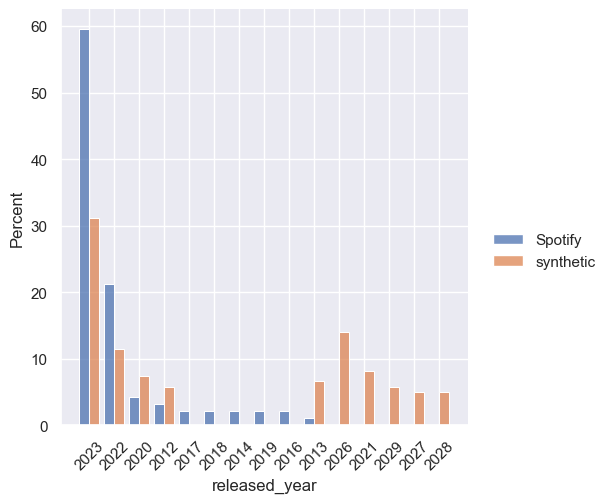

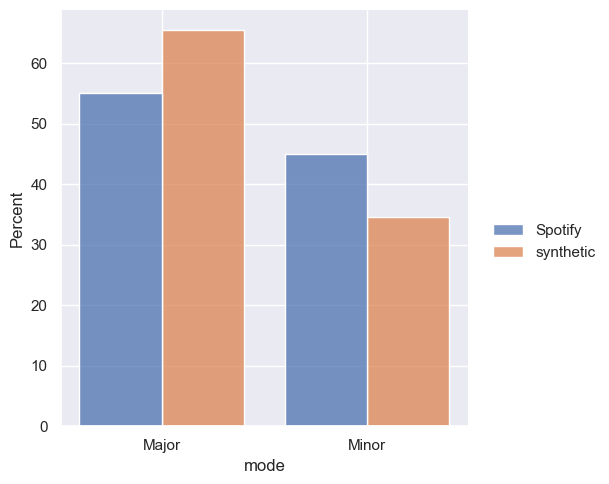

In [39]:
for col in ["released_year", "mode"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")

**2. numerical columns**


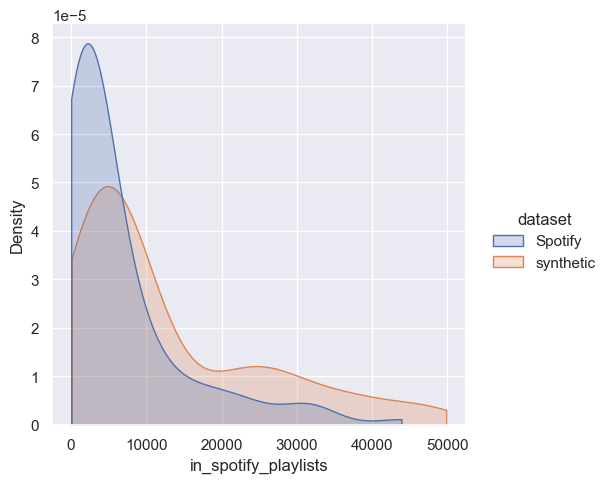

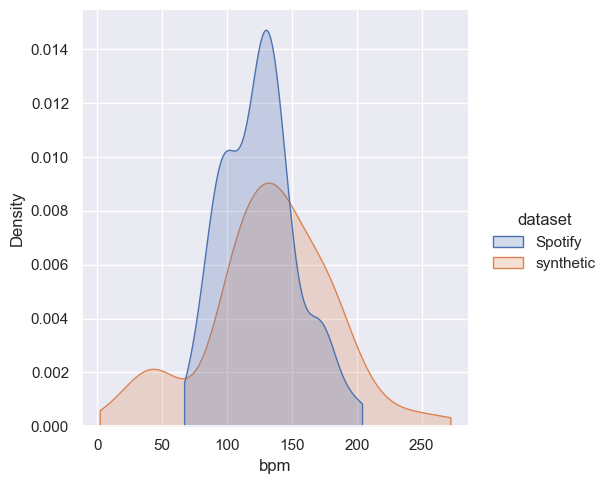

In [40]:
for col in ["in_spotify_playlists", "bpm"]:
    rf.labs.vis.plot_kde([dataset, syn], col)